# CS 171 Final Project — Analysis and Visualization Notebook

This notebook:

1. Load the processed dataset and trained `PlayerValueMLP` model.
2. Evaluate prediction quality on the test set (RMSE and baseline comparison).
3. Visualize true vs predicted player market values.
4. Analyze correlations between features (including event rates) and log market value.
5. Use `game_events.csv` together with `club_games.csv` to explore how team event patterns
   (goals, cards, substitutions) relate to match outcomes.


In [14]:
import os
import numpy as np
import pandas as pd

import torch
from torch import nn

import matplotlib.pyplot as plt

# Seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [15]:
# Device selection
if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
print('Using device: ' + device_name)
device = torch.device(device_name)


Using device: mps


In [16]:
# Load processed data
data = np.load("processed_player_value_dataset.npz")

X_train = data["X_train"]
X_val = data["X_val"]
X_test = data["X_test"]

y_train = data["y_train"]
y_val = data["y_val"]
y_test = data["y_test"]

feature_names = data["feature_names"]

input_size = X_train.shape[1]

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (12529, 22) (12529,)
Val: (4177, 22) (4177,)
Test: (4177, 22) (4177,)


In [17]:
# Reconstruct the model and load trained weights
class PlayerValueMLP(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(PlayerValueMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.net(x)

model = PlayerValueMLP(input_size).to(device)
model.load_state_dict(torch.load("player_value_mlp.pt", map_location=device))
model.eval()


PlayerValueMLP(
  (net): Sequential(
    (0): Linear(in_features=22, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [18]:
# Predictions on the test set
X_test_tensor = torch.tensor(X_test).float().to(device)

with torch.no_grad():
    y_pred_test_tensor = model(X_test_tensor).squeeze()

y_pred_test_log = y_pred_test_tensor.cpu().numpy()
y_test_log = y_test

# Convert back to euro market values for interpretability
y_pred_test_val = np.exp(y_pred_test_log)
y_test_val = np.exp(y_test_log)

print("First 5 true values (EUR):", y_test_val[:5])
print("First 5 predicted values (EUR):", y_pred_test_val[:5])


First 5 true values (EUR): [ 200000.03   399999.88    24999.992  399999.88  1200000.2  ]
First 5 predicted values (EUR): [ 379107.97 1422754.2   149242.56  345216.62  951511.6 ]


In [19]:
# Evaluation: RMSE vs a simple baseline
def rmse(a, b):
    return np.sqrt(((a - b) ** 2).mean())

# RMSE in log-space
rmse_log = rmse(y_pred_test_log, y_test_log)

# Baseline: always predict mean log market value from the training set
baseline_log = y_train.mean()
baseline_pred_log = np.full_like(y_test_log, baseline_log)
baseline_rmse_log = rmse(baseline_pred_log, y_test_log)

# RMSE in euros
rmse_val = rmse(y_pred_test_val, y_test_val)
baseline_val = np.exp(baseline_log)
baseline_rmse_val = rmse(np.full_like(y_test_val, baseline_val), y_test_val)

print("RMSE (log market value):")
print("  Model:", rmse_log)
print("  Baseline:", baseline_rmse_log)
print()
print("RMSE (market value in EUR):")
print("  Model:", rmse_val)
print("  Baseline:", baseline_rmse_val)


RMSE (log market value):
  Model: 1.0397934
  Baseline: 1.5447913

RMSE (market value in EUR):
  Model: 5133419.0
  Baseline: 6718771.0


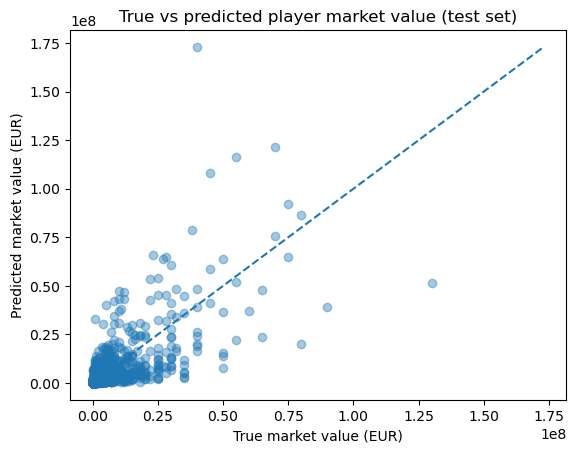

In [20]:
# Scatter plot: true vs predicted market value (test set)
plt.figure()
plt.scatter(y_test_val, y_pred_test_val, alpha=0.4)
max_val = max(y_test_val.max(), y_pred_test_val.max())
plt.plot([0, max_val], [0, max_val], linestyle="--")
plt.xlabel("True market value (EUR)")
plt.ylabel("Predicted market value (EUR)")
plt.title("True vs predicted player market value (test set)")
plt.show()


## Feature correlations with log market value

We compute Pearson correlations between each feature (including event-rate features)
and the target `log_market_value` to see which patterns are most strongly associated
with higher player valuation.


In [21]:
# Combine all splits for correlation analysis
X_all = np.vstack([X_train, X_val, X_test])
y_all_log = np.concatenate([y_train, y_val, y_test])

X_all_df = pd.DataFrame(X_all, columns=feature_names)
X_all_df["log_market_value"] = y_all_log

X_all_df.head()


,games_played,total_minutes,total_goals,total_assists,total_yellow_cards,total_red_cards,wins,win_rate,height_in_cm,age_years,...,events_subs_in_per90,events_shootout_per90,position_Defender,position_Goalkeeper,position_Midfield,position_Missing,foot_both,foot_left,foot_right,log_market_value
0,1.507655,1.443441,0.866875,2.330361,1.091881,-0.453788,1.520678,0.877411,-1.20887,0.164030,...,-0.397791,-0.157128,-0.696283,-0.284164,1.516228,-0.039986,-0.217303,1.755257,-1.462638,12.206073
1,-0.831358,-0.802981,-0.421744,-0.498204,-0.701737,-0.453788,-0.635006,1.125187,-0.01711,-1.289136,...,0.927473,-0.157128,1.436138,-0.284164,-0.659562,-0.039986,-0.217303,-0.569684,0.683695,12.611538
2,-0.580342,-0.636025,-0.260667,-0.417388,-0.573621,-0.453788,-0.544241,-0.516744,0.57877,0.178271,...,0.298466,-0.157128,-0.696283,-0.284164,-0.659562,-0.039986,-0.217303,-0.569684,0.683695,11.512925
3,-0.135359,-0.078650,-0.368052,-0.417388,0.259130,-0.453788,0.181884,1.686095,-0.61299,-1.252438,...,-0.430455,-0.157128,-0.696283,-0.284164,1.516228,-0.039986,-0.217303,-0.569684,0.683695,16.300417
4,-0.534702,-0.395791,-0.368052,-0.013307,-0.317390,1.013061,-0.612315,-1.358406,-1.20887,0.061601,...,-0.553084,0.571477,1.436138,-0.284164,-0.659562,-0.039986,-0.217303,1.755257,-1.462638,13.815511


In [22]:
# Correlations between features and log market value
corrs = []

for col in feature_names:
    if X_all_df[col].std() == 0:
        continue
    c = np.corrcoef(X_all_df[col], X_all_df["log_market_value"])[0, 1]
    corrs.append((col, c))

# Sort by absolute correlation
corrs_sorted = sorted(corrs, key=lambda x: abs(x[1]), reverse=True)

# Show top 15 features
top_corrs = corrs_sorted[:15]
top_corrs


[('age_years', -0.42241032444141063),
 ('wins', 0.38656216699572343),
 ('games_played', 0.35289733739591506),
 ('total_minutes', 0.3227191956486448),
 ('win_rate', 0.3186009800465206),
 ('total_assists', 0.31063205328690385),
 ('total_goals', 0.27843504465221797),
 ('total_yellow_cards', 0.24255903592221953),
 ('total_red_cards', 0.11914429876991903),
 ('events_cards_per90', -0.09450757779990653),
 ('events_subs_in_per90', -0.0780672871026059),
 ('position_Goalkeeper', -0.055002555126980705),
 ('foot_both', -0.04466145723892318),
 ('events_shootout_per90', -0.03727928058316052),
 ('events_goals_per90', 0.031925923415592035)]

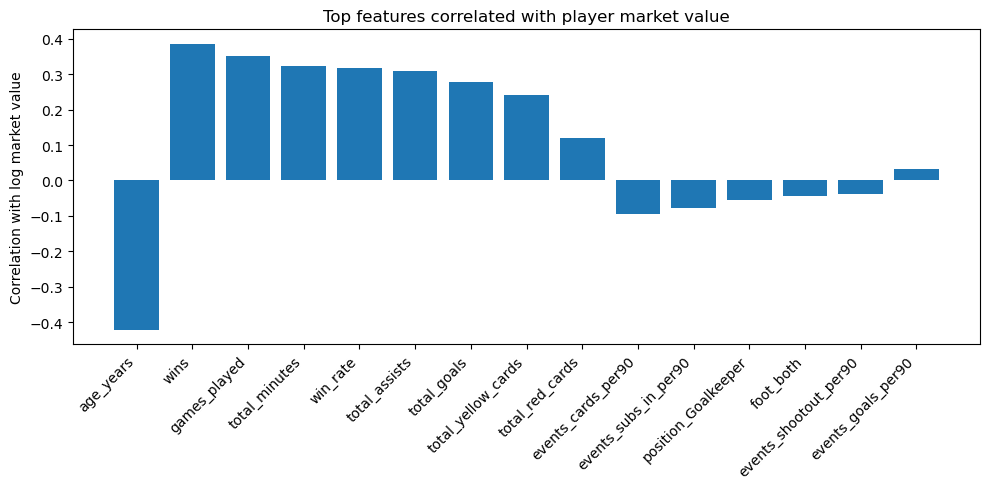

In [23]:
# Bar plot for top correlated features
top_features = [c[0] for c in top_corrs]
top_values = [c[1] for c in top_corrs]

plt.figure(figsize=(10, 5))
plt.bar(range(len(top_features)), top_values)
plt.xticks(range(len(top_features)), top_features, rotation=45, ha="right")
plt.ylabel("Correlation with log market value")
plt.title("Top features correlated with player market value")
plt.tight_layout()
plt.show()


## Event patterns and match outcomes (game_events + club_games)

To connect **team event patterns** to **match outcomes**, we:

1. Build a club-game-level table with counts of goals, cards, substitutions, and shootout events
   from `game_events.csv`.
2. Merge with `club_games.csv`, which includes `is_win` (whether the club won that match).
3. Compare average event counts between wins and non-wins.


In [24]:
# Load raw event and club-game data for this analysis
data_dir = "archive"

game_events = pd.read_csv(os.path.join(data_dir, "game_events.csv"))
club_games = pd.read_csv(os.path.join(data_dir, "club_games.csv"))

# Basic cleaning
game_events["date"] = pd.to_datetime(game_events["date"], errors="coerce")

# We aggregate counts of each event type per (game_id, club_id)
event_counts_gc = game_events.groupby(["game_id", "club_id", "type"]).size().unstack(fill_value=0)

# Make sure all expected columns exist
for col in ["Goals", "Cards", "Substitutions", "Shootout"]:
    if col not in event_counts_gc.columns:
        event_counts_gc[col] = 0

event_counts_gc = event_counts_gc.reset_index().rename(columns={
    "Goals": "team_goals_events",
    "Cards": "team_cards_events",
    "Substitutions": "team_subs_events",
    "Shootout": "team_shootout_events"
})

event_counts_gc.head()


type,game_id,club_id,team_cards_events,team_goals_events,team_shootout_events,team_subs_events
0,2211607,383,2,4,0,2
1,2211607,610,5,2,0,3
2,2218677,506,3,4,0,3
3,2218677,6195,7,2,0,3
4,2219794,58,2,3,0,3


In [25]:
# Merge with club_games to get match outcome (is_win)
club_small = club_games[["game_id", "club_id", "is_win"]].copy()

club_events = club_small.merge(
    event_counts_gc,
    on=["game_id", "club_id"],
    how="left"
)

# Replace missing event counts with zero
for col in [
    "team_goals_events",
    "team_cards_events",
    "team_subs_events",
    "team_shootout_events"
]:
    club_events[col] = club_events[col].fillna(0)

club_events.head()


,game_id,club_id,is_win,team_cards_events,team_goals_events,team_shootout_events,team_subs_events
0,2320450,1468.0,0,1.0,0.0,0.0,3.0
1,2320454,222.0,0,1.0,0.0,0.0,3.0
2,2320460,1.0,1,3.0,3.0,0.0,3.0
3,2320472,2036.0,0,4.0,1.0,0.0,3.0
4,2321027,33.0,0,1.0,3.0,0.0,2.0


In [26]:
# Compare average event counts for wins vs non-wins
win_group = club_events[club_events["is_win"] == True]
nonwin_group = club_events[club_events["is_win"] == False]

summary = pd.DataFrame({
    "wins_mean_goals": [win_group["team_goals_events"].mean()],
    "nonwins_mean_goals": [nonwin_group["team_goals_events"].mean()],
    "wins_mean_cards": [win_group["team_cards_events"].mean()],
    "nonwins_mean_cards": [nonwin_group["team_cards_events"].mean()],
    "wins_mean_subs": [win_group["team_subs_events"].mean()],
    "nonwins_mean_subs": [nonwin_group["team_subs_events"].mean()]
})

summary


,wins_mean_goals,nonwins_mean_goals,wins_mean_cards,nonwins_mean_cards,wins_mean_subs,nonwins_mean_subs
0,2.430102,0.723002,1.946179,2.289846,3.430136,3.325743


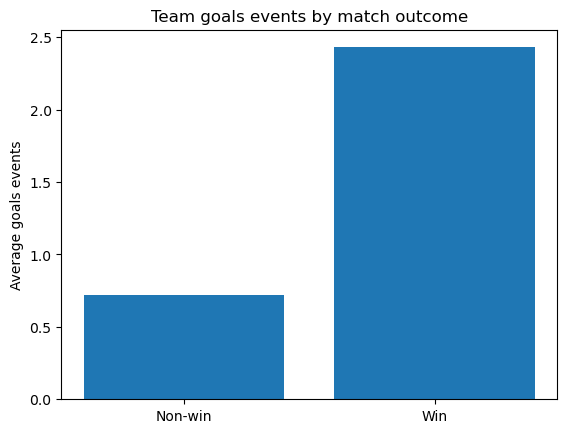

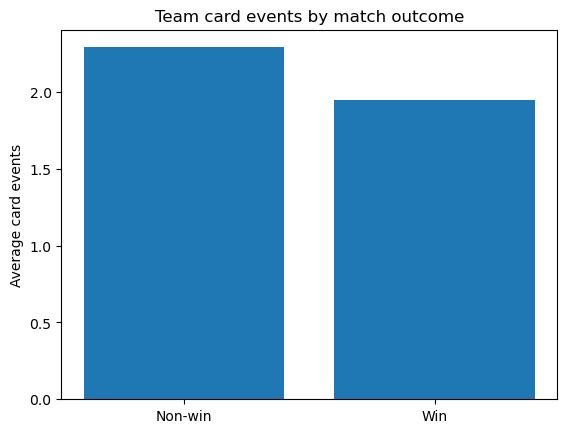

In [27]:
# Simple bar plots: goals and cards vs match outcome
labels = ["Non-win", "Win"]

# Goals events
goals_means = [
    nonwin_group["team_goals_events"].mean(),
    win_group["team_goals_events"].mean()
]
plt.figure()
plt.bar(labels, goals_means)
plt.ylabel("Average goals events")
plt.title("Team goals events by match outcome")
plt.show()

# Cards events
cards_means = [
    nonwin_group["team_cards_events"].mean(),
    win_group["team_cards_events"].mean()
]
plt.figure()
plt.bar(labels, cards_means)
plt.ylabel("Average card events")
plt.title("Team card events by match outcome")
plt.show()
